# Парсер

При работе с сылками на статьи с ресурса Arxiv.org

In [ ]:
pip install BeautifulSoup4

In [ ]:
import re
from bs4 import BeautifulSoup
import requests

url = 'https://arxiv.org/abs/2402.15030'

In [ ]:
import pandas as pd
import pickle

In [ ]:
headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 OPR/107.0.0.0"
}

In [ ]:
req = requests.get(url=url, headers=headers)

In [ ]:
src = req.text

In [ ]:
soup = BeautifulSoup(src, "lxml")

<ipython-input-7-7e7a0a7b1572>:1: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(src, "lxml")


In [ ]:
abstracts = soup.find_all(class_='abstract mathjax')

In [ ]:
list_abstracts = []
for item in abstracts:
  el = item.text
  el  = re.sub(r"\n","", el)
  el  = re.sub(r"    ","", el)
  el  = re.sub(r"Abstract:","", el)
  list_abstracts.append(el)

In [ ]:
titles = soup.find_all(class_='title mathjax')

In [ ]:
list_titles = []
for item in titles:
  el = item.text
  el  = re.sub(r"\n","", el)
  el  = re.sub(r"Title:","", el)
  list_titles.append(el)

In [ ]:
list_titles

['Adjusting for Ascertainment Bias in Meta-Analysis of Penetrance for Cancer Risk']

In [ ]:
list_labels = [0]*len(list_titles)

Запись данных в один датасет

In [ ]:
df = pd.DataFrame(list(zip(list_titles, list_abstracts, list_labels, list_links)), columns = ['Название', 'Абстракт', 'Метка', 'Ссылка'])

# Эксплуатация

Идея оптимизированного метода заключается в том, что тексты более и менее 512 токенов обрабатываются отдельно.

В начале необходимо отсортировать тексты по длине входной последовательности. Тексты длиной менее 512 токенов образуют группу А, а более - группу В, как показано на рисунке 15. Таким образом, сформированы два блока текстов, группа А – не требует разбиения на сегменты, группа В содержит только длинные тексты, именно к ней применяется метод по разбиению текстов на сегменты

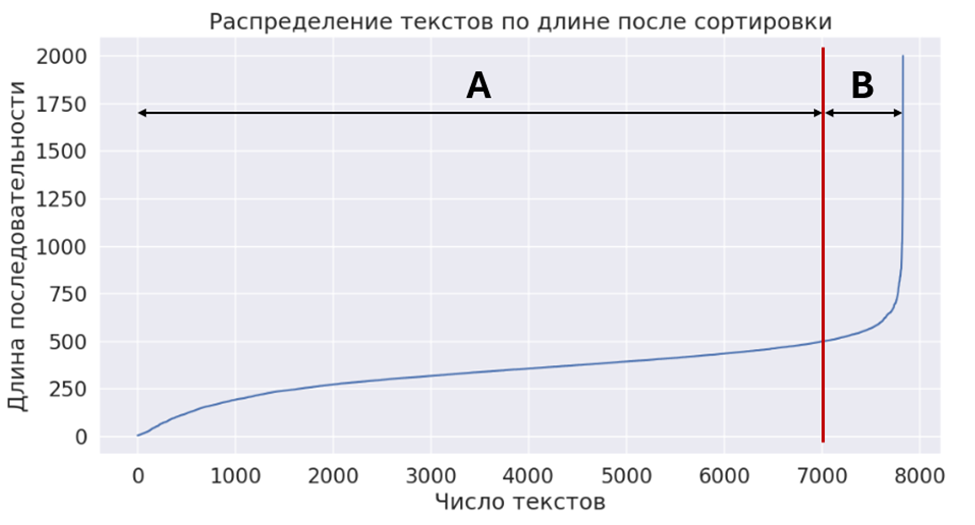

## Загрузка и предобработка данных

In [ ]:
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

В качестве набора данных используются данные медицинских статей, полученные с платформы Arxiv.org


[Ссылка](https://www.kaggle.com/datasets/ekaterinamayatskaya/medical-articles)

In [ ]:
df = pd.read_pickle('df.pkl')

In [ ]:
df =  df[['Абстракт', 'Метка']]

In [ ]:
label_encoder = LabelEncoder()
df['Метка'] = label_encoder.fit_transform(df['Метка'])

Оценка длины корпуса текстов

In [ ]:
df["length"] = df["Абстракт"].apply(lambda x : len(x.split()))

print("Train Length Stat")
print(df["length"].describe())

Train Length Stat
count    3795.000000
mean      180.003162
std        60.718983
min        18.000000
25%       139.000000
50%       179.000000
75%       223.500000
max       685.000000
Name: length, dtype: float64


Максимальная длина текста в корпусе 658 токенов, при ограничении модели BERT 512 токенов

In [ ]:
df.reset_index(drop=True, inplace=True)

Сохранение текстов менее 512 токенов в отдельный датасет

In [ ]:
df_less=df
for i in range(len(df["Абстракт"])):
    if df["length"][i] > 510:
        # print(i)
        df_less = df_less.drop(index= i)

503
780
1103
3065


Сохранение текстов более 512 токенов в отдельный датасет

In [ ]:
df_more=df
for i in range(len(df["Абстракт"])):
    if df["length"][i] < 510:
        df_more = df_more.drop(index= i)

## Работа с текстами менее 512 токенов

### Кодировка текста

Функция случайного выбора батча

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
        Эта функция пытается выбрать интеллектуальный интервал обновления выбора батча
        на основе величины общего количества итераций.

        Параметры:
            `total_iters` - количество итераций в цикле for.
            `num_desired_updates` - сколько раз мы хотим видеть обновление в течение цикла for.
    '''
    # Разделить общее количество итераций на желаемое количество обновлений.
    # Получится не очень красиво число
    exact_interval = total_iters / num_desired_updates


    # Чтобы определить величину, до которой нужно округлить, найдите величину итогового значения,
    # а затем уменьшите ее на одну величину.

    # Получите порядок величины от общего числа.
    order_of_mag = len(str(total_iters)) - 1

    # Интервал обновления должен быть округлен на порядок меньше.
    round_mag = order_of_mag - 1

    # Округлить в меньшую сторону и преобразовать в int.
    update_interval = int(round(exact_interval, -round_mag))

    # Не допускать, чтобы интервал был равен нулю!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Принимает время в секундах и возвращает строку чч:мм:сс
    '''
    # Округлить до ближайшей секунды.
    elapsed_rounded = int(round((elapsed)))

    # Формат вывода hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Загрузка токенизатора и модели BERT, в качестве базовой модели взят трансформер предобученный на медицинских статьях

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import  BertModel

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

Модели необходимо указать устройство для проведения всех математических операций

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print('  GPU:', torch.cuda.get_device_name(0))


  GPU: Tesla T4


Выделение меток, текстов и максимальной длины

In [ ]:
labels = df_less['Метка'].to_numpy()

In [ ]:
corpus = df_less['Абстракт'].to_numpy()

In [ ]:
max_len = df_less["length"].max()

Функция формирования батчей, описанным методом

In [ ]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    Эта функция объединяет все необходимые шаги для приготовления батчей.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Токенизация & Усечение
    # =========================

    full_input_ids = []

    # Токенизация всех сэмплов
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Выбрать интервал обновления батчей
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # Для каждого тренировочного сэмпла проводим токенизацию
    for text in text_samples:

        # Отчет о прогрессе
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Токенизация
        input_ids = tokenizer.encode(text=text,              # Текст для кодировки
                                    add_special_tokens=True, # Добавить специальные токены
                                    max_length=max_len,      # Максимальная длина обрезания текста
                                    truncation=True,         # Маркер необходимо ли усечение
                                    padding=False)           # Маркер необходим ли паддинг

        # Добавляем результат в список
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Выбор батчей
    # =========================

    # Отсортируем два списка вместе по длине входной последовательности.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # Список батчей, которые мы создадим.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Выберите интервал обновления батчей
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Проходимся по всем сэмплам
    while len(samples) > 0:

        # Вывод прогресса
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` - это фактический размер партии. Он будет `batch_size` до тех пор, пока
        # мы не дойдем до последней партии, которая может быть меньше.
        to_take = min(batch_size, len(samples))

        # Выберите случайный индекс в списке оставшихся батчей, чтобы проводить
        # отбор случайно
        select = random.randint(0, len(samples) - to_take)

        # Выберите непрерыную партию батчей начиная с `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Каждый образец представляет собой кортеж - разделите их на части, чтобы создать отдельный список
        # последовательностей текста и список меток для этого пакета.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Удаляем из списка уже использованные батчи
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Добавка паддинга
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []
    lab=[]
    # Для каждого батча..
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # Новая версия батча, на этот раз с дополненными последовательностями до максимальной длины, а также
        # с маской внимания.
        batch_padded_inputs = []
        batch_attn_masks = []

        # Сначала найдите самый длинный образец в батче.
        # Обратите внимание, что в настоящее время последовательности содержат специальные токены!
        max_size = max([len(sen) for sen in batch_inputs])

        # Для каждого текста в батче
        for sen in batch_inputs:

            # Сколько специальных токенов необходимо добавить
            num_pads = max_size - len(sen)

            # Добавьте токены заполнения `num_pads` в конец последовательности.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Определить маску внимания, это - `1` для реального токена
            # и - `0` для специального токена
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Добавить результат в список
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # В каждом батче был проведен паддинг, поэтому нам нужно сохранить этот обновленный пакет.
        # Нам также нужно, чтобы входные данные были тензорами PyTorch.
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
        lab.append(batch_labels)


    print('  DONE.')

    # Возвращаем данные
    return (py_inputs, py_attn_masks, py_labels, lab)

Гиперпараметры

In [ ]:
batch_size=8

Функция, производящая взятие среднего для вектора каждого слова

Слой last_hidden_state выдает вектор размерности 3, где для каждого слова формируется вектор размерности 768, работа с такими данными требует больших вычислительных ресурсов. Для решения данной проблемы необходимо взять среднее значение для векторов слов. На выходе получаем, что каждое слово характеризуется одним числом, каждый текст - это вектор размерности 768

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

Токенизация текста

In [ ]:
(py_inputs, py_attn_masks, py_labels, labe) = make_smart_batches(corpus,labels, batch_size)

Creating Smart Batches from 3,791 examples with batch size 8...

Tokenizing 3,791 samples...
  Tokenized 0 samples.
  Tokenized 400 samples.
  Tokenized 800 samples.
  Tokenized 1,200 samples.
  Tokenized 1,600 samples.
  Tokenized 2,000 samples.
  Tokenized 2,400 samples.
  Tokenized 2,800 samples.
  Tokenized 3,200 samples.
  Tokenized 3,600 samples.
DONE.
     3,791 samples

     3,791 samples after sorting

Creating batches of size 8...
  Selected 400 batches.

  DONE - Selected 474 batches.

Padding out sequences within each batch...
  DONE.


Получение векторных представлений корпуса текстов

In [ ]:

model.eval()

lab=torch.Tensor().to(device)
embeddings = torch.Tensor().to(device)

# Выбор интервала обновления
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=16)

# Фиксирование времени начала
t0 = time.time()

# Переведите модель в режим оценки
model.eval()
latency = []
# Проходимся по каждому батчу
for step in range(0, len(py_inputs)):

    # Вывод прогресса для каждый 100 батчей
    if step % update_interval == 0 and not step == 0:

        elapsed = format_time(time.time() - t0)

        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)


        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Передача данных на GPU
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)


    with torch.no_grad():
        start = time.time()
        result = model(b_input_ids)
        latency.append(time.time() - start)
        embeddings = torch.cat([embeddings, mean_pooling(result, b_input_mask)])
embeddings = embeddings.cpu().numpy()
print("PyTorch {} Inference time = {} ms".format(device.type, format(sum(latency) * 1000 / len(latency), '.2f')))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


  Batch      30  of      474.    Elapsed: 0:00:05.  Remaining: 0:01:20
  Batch      60  of      474.    Elapsed: 0:00:09.  Remaining: 0:01:04
  Batch      90  of      474.    Elapsed: 0:00:13.  Remaining: 0:00:57
  Batch     120  of      474.    Elapsed: 0:00:17.  Remaining: 0:00:51
  Batch     150  of      474.    Elapsed: 0:00:21.  Remaining: 0:00:46
  Batch     180  of      474.    Elapsed: 0:00:25.  Remaining: 0:00:41
  Batch     210  of      474.    Elapsed: 0:00:30.  Remaining: 0:00:37
  Batch     240  of      474.    Elapsed: 0:00:34.  Remaining: 0:00:33
  Batch     270  of      474.    Elapsed: 0:00:38.  Remaining: 0:00:29
  Batch     300  of      474.    Elapsed: 0:00:42.  Remaining: 0:00:24
  Batch     330  of      474.    Elapsed: 0:00:46.  Remaining: 0:00:20
  Batch     360  of      474.    Elapsed: 0:00:50.  Remaining: 0:00:16
  Batch     390  of      474.    Elapsed: 0:00:53.  Remaining: 0:00:12
  Batch     420  of      474.    Elapsed: 0:00:58.  Remaining: 0:00:07
  Batc

### Классификация

In [ ]:
import keras

In [ ]:
labe_list = [item for sublist in labe for item in sublist]

Загрузка предобученной реккурентой сети

In [ ]:
model_lstm_batch = keras.models.load_model('model_lstm_batch.keras')

In [ ]:
emb=np.array(embeddings)

Добавление третьего временного измерения. Это необходимо для подачи данных в рекурентную нейронную сеть!

In [ ]:
emb = np.expand_dims(emb, 1)

In [ ]:
labe_list = np.asarray(labe_list)

Получение предсказаний

In [ ]:
y_pred = model_lstm_batch.predict(emb, batch_size=500, verbose=1)
y_pred_b = np.argmax(y_pred, axis=1)

8/8 [==============================] - 1s 9ms/step


In [ ]:
df_less['Метка'] = y_pred_b

## Работа с текстами более 512 токенов

### Кодировка текста

Загрузка обученной модели BERT и модели LSTM для классификации

In [ ]:
model_bert = torch.load('bert_model')

In [ ]:
model_lstm = keras.models.load_model('model_lstm.keras')

In [ ]:
DATA_COLUMN = 'Абстракт'
LABEL_COLUMN = 'Метка'

label_list = [x for x in np.unique(df_more['Метка'])]
label_list

[0, 8]

Разбиение текстов на сегменты по 510 токенов каждый с перекрытием в 50 токенов

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//460 >0:
    n = len(text1.split())//460
  else:
    n = 1
  for w in range(n+1):
    if w == 0:
      l_parcial = text1.split()[:510]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*460:w*460 + 510]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
df_more['text_split'] = df_more[DATA_COLUMN].apply(get_split)
df_more

,Абстракт,Метка,length,text_split
503,ETHNOPHARMACOLOGICAL RELEVANCE: As a commonly ...,8,660,[ETHNOPHARMACOLOGICAL RELEVANCE: As a commonly...
780,STUDY QUESTION: Are differences in androgen le...,0,685,[STUDY QUESTION: Are differences in androgen l...
1103,STUDY QUESTION: Is psychosocial stress associa...,0,511,[STUDY QUESTION: Is psychosocial stress associ...
3065,STUDY QUESTION: Is bisphenol A (BPA) exposure ...,0,674,[STUDY QUESTION: Is bisphenol A (BPA) exposure...


In [ ]:
for i in df_more['text_split']:
  if '' in i:
    i.remove('')

In [ ]:
df_more.reset_index(drop=True, inplace=True)

Разбиение данных на три списка содержащих сами тектсы, метки и индексы каждого текста для обратного объединения сегментов текста

In [ ]:
test_l = []
label_test_l = []
index_test_l =[]
for idx,row in df_more.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    label_test_l.append(row['Метка'])
    index_test_l.append(idx)
len(test_l), len(label_test_l), len(index_test_l)

(8, 8, 8)

In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:label_test_l})

In [ ]:
corpus_test = test_df['Абстракт'].to_numpy()
sample_labels_test = test_df['Метка'].to_numpy()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split

Токенизация текста. На выходе имеем два тензора с закондированными текстами и маской, указывающей на наличие специального токена заполнения PAD

In [ ]:
test_input_ids = []
test_attention_masks = []
for tweet in corpus_test:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = 510,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Для дальнейшей подачи данных в модель трансформера необходимо представить их в виде DataLoader

In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset), # Берем батчи последовательно
            batch_size = 3
        )

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[1][0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

Выполнение предсказаний загруженной ранее моделью BERT

In [ ]:
predictions = []
embeddings = torch.Tensor().to(device)
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model_bert(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask, output_hidden_states = True)
            # print(output[1].shape)
            embeddings = torch.cat([embeddings, mean_pooling(output, b_input_mask)])

            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))
embeddings = embeddings.cpu().numpy()

In [ ]:
embeddings_test = embeddings

In [ ]:
test_emb = embeddings_test

Объединяем сегменты текстов

In [ ]:
aux = -1
len_l = 0
test_x = {}
for l, emb in zip(index_test_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]

len(test_x.keys())

4

Получаем полученные объединенные векторные представления от модели трансформера и соответствующие метки

In [ ]:
test_l_final = []
label_test_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  label_test_l_final.append(df_more.loc[k]['Метка'])

df_test_true = pd.DataFrame({'emb': test_l_final, 'label': label_test_l_final, })
df_test_true.head()

,emb,label
0,"[[-0.005423272, 0.09883099, 0.10688911, 0.0806...",8
1,"[[0.03969249, 0.088324286, 0.22027038, -0.0202...",0
2,"[[0.052948043, 0.1777511, 0.14543754, 0.072575...",0
3,"[[0.054888383, 0.074569985, 0.13509154, 0.0952...",0


### Классификация

In [ ]:
test_emb  = df_test_true

Приведение эмбеддингов к одной длине

In [ ]:
def together(df):
    df["length"] = df['emb'].apply(lambda x : len(x))
    max_lenght = 4

    x_list= df['emb'].to_list()
    y_list = df.label.to_list()

    embs=[]
    labels_y=[]

    for i in range(len(x_list)):
        x_train = np.full((768*max_lenght), -99.)
        y_train = np.zeros((1))

        if len(x_list[i])==1:
            x_train[0:768] = x_list[i][0]
            y_train = y_list[i]
        else:
            num=len(x_list[i])
            x_train[0:768*num] = x_list[i].reshape(1, 768*num)
            y_train = y_list[i]

        embs.append(x_train)
        labels_y.append(y_train)
    return embs, labels_y

In [ ]:
embs, labels = together(test_emb)

In [ ]:
embs = np.asarray(embs)

In [ ]:
labels = np.asarray(labels)

In [ ]:
emb_new = np.expand_dims(embs, 1)

Создание маски для указание модели на специальный токен заполения (аналогично токенизатору модели BERT)

In [ ]:
import torch
import torch.nn as nn

bert_embeddings = torch.tensor(emb_new)
ignore_value_mask = (bert_embeddings != -99.)

masked_bert_embeddings_test = bert_embeddings * ignore_value_mask.float()

In [ ]:
masked_bert_embeddings_test = np.asarray(masked_bert_embeddings_test)

In [ ]:
y_pred = model_lstm.predict(masked_bert_embeddings_test, batch_size=1000, verbose=1)
y_pred_b = np.argmax(y_pred, axis=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
df_more['Метка'] = y_pred_b

Объединение результатов классификации двух блоков менее и более 512 токенов

In [ ]:
df_all = pd.concat([df_less, df_more])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:

report = classification_report(
    df_all['True_label'],
    df_all['Pred_label'],

)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       653
           1       0.89      0.87      0.88       345
           2       0.75      0.80      0.77       137
           3       0.84      0.95      0.90       288
           4       0.88      0.72      0.79       193
           5       0.91      0.83      0.87       148
           6       0.86      0.86      0.86      1231
           7       0.91      0.85      0.88       136
           8       0.76      0.81      0.78       354
           9       0.84      0.84      0.84       310

    accuracy                           0.85      3795
   macro avg       0.85      0.84      0.84      3795
weighted avg       0.85      0.85      0.85      3795



### Соотношение меток

In [ ]:
encoded_labels = df['Метка']

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Соотношение реальных меток и новых меток:")
for label, encoded_label in label_mapping.items():
    print(f"{label}: {encoded_label}")


Соотношение реальных меток и новых меток:
cancer: 0
immunity: 1
immunodeficiency: 2
inflammation: 3
rheumatoid arthritis: 4
sepsis: 5
systemic lupus erythematosus: 6
tuberculosis: 7
